In [1]:
%config Completer.use_jedi = False

In [2]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
from tlefit_equinoctial_eph_fd import *

In [5]:
import coord_skyfield
from coord_skyfield import ITRF2TEME

In [6]:
df = pd.read_feather('ephemeris/icesat.fth')

t = df.timestamp
ephemeris = [((row['x'], row['y'], row['z']), (row['xdot'], row['ydot'], row['zdot'])) for idx, row in df.iterrows()]

ephemeris_teme = ITRF2TEME(t, ephemeris)
ephemeris = ephemeris_teme
t = np.array([_t.to_pydatetime() for _t in t])

/tmp/ipykernel_821344/3202393328.py:8: UserWarning: Discarding nonzero nanoseconds in conversion.
  t = np.array([_t.to_pydatetime() for _t in t])


In [7]:
last_obs = 2500
obs_stride = 2
lamda = 1e-3 * 0 + 1 # Interesting.The smaller number works, but diverges. This is better
iterations, solve_sat, elements_coe, sigma, sigmas, dxs, bs, lamdas, b_epoch, b_new_epoch, b, P, A = \
test_tle_fit_normalized_equinoctial(t, ephemeris, central_diff=True, last_obs=last_obs, obs_stride=obs_stride, lamda=lamda, rms_epsilon=0.0001, debug=True)

Initial semi-major axis (a) = 6964.748 km
COE elements (original) = [6964.747920163459, 0.0008532659302083011, 1.6406707565495493, 3.510973090900842, 0.0219135748417416, 1.9295921006576968, 1e-06]
Residuals at epoch time [ 2.17569220e+00  5.78270795e-01 -7.90739972e+00  1.39443640e-03
  6.33258238e-04 -6.85567605e-04]
Residual magnitudes at epoch time 8.22162, 0.00167794


#################### ITERATION 1 ####################

Condition number (A): 11.640
Condition number (ATWA_acc): 837733.0464943255
Lambda:  0.1
Residuals after/before 3.06e+09 < 2.43e+13
Covariance a: 0.011 m
dx  [ 1.01750888e+01  9.19475347e-04  2.33653445e-04 -3.56839801e-04
  1.05800825e-04  2.97603646e-05 -8.12654430e-03]
COE elements = [6974.923008962788, 0.00015970199364974494, 1.6406094112810417, 3.510891104099522, 2.1601439519581467, 6.074272177720742, -0.008125544299055461]
EQN elements = (6974.923008962788, 0.0001307023977437938, -9.176933038726119e-05, 5.462121926598822, -0.3870835374682497, -1.00007039148

In [8]:
# Split the data into in-spampe and out-of-sample

# Optionally thin the observations
t_is = tt = t[::obs_stride]
eph_is = teph = ephemeris[::obs_stride]

if last_obs:
    t_os = t_is[last_obs:]
    t_is = t_is[:last_obs]
    eph_os = eph_is[last_obs:]
    eph_is = eph_is[:last_obs]
    
jd, jdf = solve_sat.model.jdsatepoch, solve_sat.model.jdsatepochF
print(sat_epoch_datetime(solve_sat.model))

2003-02-21 14:38:46.999679+00:00


In [9]:
exporter.export_tle(solve_sat.model)

('1 99999U 1800100  03052.61026620  .00000000  00000-0 -52261-4 0  9999',
 '2 99999  94.0007 201.1588 0002102  89.4287  22.4253 14.90456728    10')

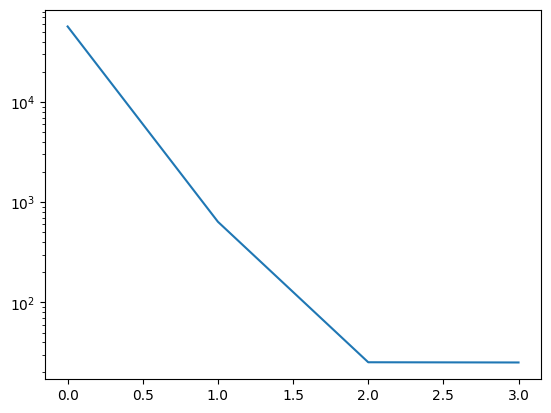

In [10]:
plt.semilogy(range(len(sigmas)), sigmas)

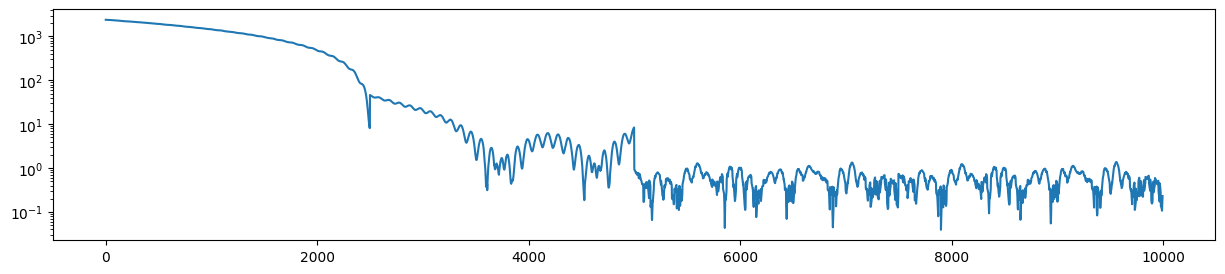

In [11]:
plt.figure(figsize=(15,3))
plt.semilogy(bs)

In [12]:
def solution_residuals(t, ephemeris, solve_sat):
    
    bs = []
    
    offset_idxs = range(len(t))
    
    for offset_idx in offset_idxs:

        # Obs - Nom
        jd, jdf = jday_datetime(t[offset_idx])
        res = np.array(ephemeris[offset_idx]) - np.array(solve_sat.model.sgp4(jd, jdf)[1:])
        
        b = np.concatenate((res[0], res[1]))

        #bs.append(np.linalg.norm(b.T @ W @ b))
        bs.append(np.linalg.norm(b.T @ b))
        
    return np.array(bs)

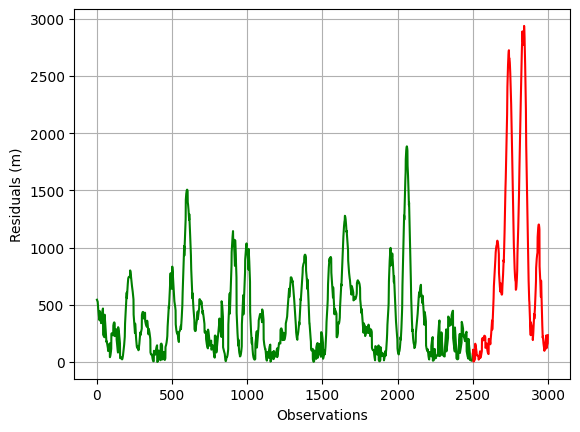

In [13]:
plt.plot(solution_residuals(t_is, eph_is, solve_sat) * 1000, c='g')
plt.plot(range(last_obs, len(tt)), solution_residuals(t_os, eph_os, solve_sat) * 1000, c='r')

plt.xlabel('Observations')
plt.ylabel('Residuals (m)')
plt.grid()

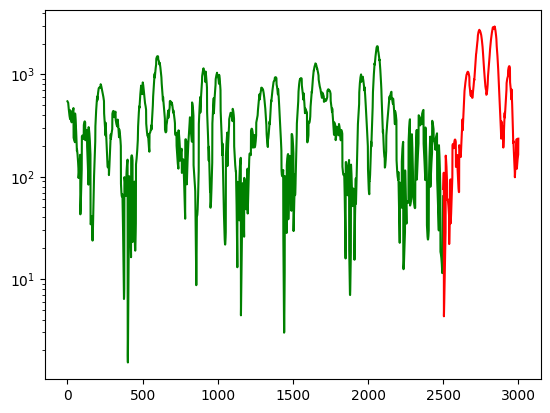

In [14]:
plt.semilogy(solution_residuals(t_is, eph_is, solve_sat) * 1000, c='g')
plt.semilogy(range(last_obs, len(tt)), solution_residuals(t_os, eph_os, solve_sat) * 1000, c='r')

## Find the distance to TLEs with the same launch and proximate epoch

In [24]:
import datetime as dt

import json

from sgp4.conveniences import sat_epoch_datetime, jday_datetime

from spacetrack import SpaceTrackClient
import spacetrack.operators as op

st = SpaceTrackClient(os.environ['SPACETRACK_USER'], os.environ['SPACETRACK_PWD'])

In [26]:
launch_objects = json.loads(st.gp(object_id=op.like('2003-002~~'), orderby='TLE_LINE1', format='json'))

In [16]:
tles = []

sat_ids = [sat['NORAD_CAT_ID'] for sat in launch_objects]

In [17]:
sat_gps = json.loads(st.gp_history(norad_cat_id=','.join(sat_ids),  epoch=op.inclusive_range((sat_epoch_datetime(solve_sat.model) - dt.timedelta(days=1)).date(), (sat_epoch_datetime(solve_sat.model) + dt.timedelta(days=+2)).date()), orderby='TLE_LINE1', format='json'))

In [18]:
def solution_residuals(t, solve_sat, comp_sat):
    
    bs = []
    
    offset_idxs = range(len(t))
    
    for offset_idx in offset_idxs:

        # Obs - Nom
        jd, jdf = jday_datetime(t[offset_idx])
        b = np.ravel(np.array(np.array(solve_sat.sgp4(jd, jdf)[1:] - np.array(comp_sat.sgp4(jd, jdf)[1:]))))[:3]

        bs.append(b.T @ b)
        
    return np.array(bs)

In [19]:
candidates = []

for sat in sat_gps:
    candidate_sat = EarthSatellite(sat['TLE_LINE1'], sat['TLE_LINE2'], sat['TLE_LINE0'], ts)

    res = solution_residuals(t_is, solve_sat.model, candidate_sat.model)
    res_epoch = np.sqrt(res[-1])
    res = np.sqrt(np.mean(res))

    candidates.append((sat["NORAD_CAT_ID"], sat["OBJECT_ID"], sat["EPOCH"], sat["TLE_LINE0"], sat["TLE_LINE1"], sat["TLE_LINE2"], res, res_epoch))

In [20]:
df_candidates = pd.DataFrame(candidates, columns=['norad_cat_id', 'object_id', 'epoch', 'tle_line0', 'tle_line1', 'tle_line2', 'residual', 'residual_epoch'])

In [21]:
df_candidates.sort_values('residual').head(20)

,norad_cat_id,object_id,epoch,tle_line0,tle_line1,tle_line2,residual,residual_epoch
4,27642,2003-002A,2003-02-21T22:12:10.555488,0 ICESAT,1 27642U 03002A 03052.92512217 +.00000334 +0...,2 27642 093.9974 201.3200 0002012 082.5177 277...,0.449454,0.481396
3,27642,2003-002A,2003-02-21T10:55:25.107744,0 ICESAT,1 27642U 03002A 03052.45515171 .00001751 0...,2 27642 093.9975 201.0818 0002009 083.8037 276...,0.491112,0.817666
5,27642,2003-002A,2003-02-22T11:05:36.259872,0 ICESAT,1 27642U 03002A 03053.46222523 .00000675 0...,2 27642 093.9973 201.5925 0001977 080.0368 280...,0.491160,0.508716
6,27642,2003-002A,2003-02-22T22:22:21.200447,0 ICESAT,1 27642U 03002A 03053.93218982 +.00000782 +0...,2 27642 093.9986 201.8315 0001994 086.8594 273...,0.531606,0.301987
2,27642,2003-002A,2003-02-21T10:55:25.021343,0 ICESAT,1 27642U 03002A 03052.45515071 .00000069 0...,2 27642 093.9989 201.0818 0002120 093.1553 266...,2.318565,4.382716
1,27642,2003-002A,2003-02-20T22:01:59.166623,0 ICESAT,1 27642U 03002A 03051.91804591 +.00000836 +0...,2 27642 093.9987 200.8086 0001693 075.4900 284...,4.443557,9.185398
0,27642,2003-002A,2003-02-20T10:45:14.378975,0 ICESAT,1 27642U 03002A 03051.44808309 .00001254 0...,2 27642 093.9987 200.5699 0002091 092.9221 267...,6.712634,12.526059
7,27643,2003-002B,2003-02-20T20:33:57.017087,0 CHIPSAT,1 27643U 03002B 03051.85690992 .00003345 0...,2 27643 094.0108 200.8645 0014256 102.5331 257...,4075.204171,2717.656738
8,27643,2003-002B,2003-02-20T22:10:24.127104,0 CHIPSAT,1 27643U 03002B 03051.92389036 +.00003321 +0...,2 27643 094.0108 200.8988 0014209 102.2272 258...,4075.418993,2717.932791
9,27643,2003-002B,2003-02-21T20:40:42.670272,0 CHIPSAT,1 27643U 03002B 03052.86160498 .00002930 0...,2 27643 094.0114 201.3792 0014474 100.7745 259...,4077.190646,2721.672327


In [22]:
df_candidates[df_candidates['object_id'] == '2003-002A'].sort_values('residual')

,norad_cat_id,object_id,epoch,tle_line0,tle_line1,tle_line2,residual,residual_epoch
4,27642,2003-002A,2003-02-21T22:12:10.555488,0 ICESAT,1 27642U 03002A 03052.92512217 +.00000334 +0...,2 27642 093.9974 201.3200 0002012 082.5177 277...,0.449454,0.481396
3,27642,2003-002A,2003-02-21T10:55:25.107744,0 ICESAT,1 27642U 03002A 03052.45515171 .00001751 0...,2 27642 093.9975 201.0818 0002009 083.8037 276...,0.491112,0.817666
5,27642,2003-002A,2003-02-22T11:05:36.259872,0 ICESAT,1 27642U 03002A 03053.46222523 .00000675 0...,2 27642 093.9973 201.5925 0001977 080.0368 280...,0.491160,0.508716
6,27642,2003-002A,2003-02-22T22:22:21.200447,0 ICESAT,1 27642U 03002A 03053.93218982 +.00000782 +0...,2 27642 093.9986 201.8315 0001994 086.8594 273...,0.531606,0.301987
2,27642,2003-002A,2003-02-21T10:55:25.021343,0 ICESAT,1 27642U 03002A 03052.45515071 .00000069 0...,2 27642 093.9989 201.0818 0002120 093.1553 266...,2.318565,4.382716
1,27642,2003-002A,2003-02-20T22:01:59.166623,0 ICESAT,1 27642U 03002A 03051.91804591 +.00000836 +0...,2 27642 093.9987 200.8086 0001693 075.4900 284...,4.443557,9.185398
0,27642,2003-002A,2003-02-20T10:45:14.378975,0 ICESAT,1 27642U 03002A 03051.44808309 .00001254 0...,2 27642 093.9987 200.5699 0002091 092.9221 267...,6.712634,12.526059


In [23]:
sat = sat_gps[6]
candidate_sat = EarthSatellite(sat['TLE_LINE1'], sat['TLE_LINE2'], sat['TLE_LINE0'], ts)
candidate_sat.model.sgp4(jd, jdf)

(0,
 (2261.219320997998, 1358.9466664175704, 6448.0213138740355),
 (6.61651017471882, 2.3507524816299354, -2.8093566278164706))

In [24]:
(np.ravel(solve_sat.model.sgp4(jd, jdf)[1:]) - np.ravel(candidate_sat.model.sgp4(jd, jdf)[1:]))[:3]

array([-0.29629112,  0.035315  ,  0.04648425])

In [25]:
solve_sat.model.sgp4_tsince(0)

(0,
 (2260.92302987888, 1358.9819814220282, 6448.067798125239),
 (6.616808293645903, 2.3505005636228646, -2.809007196821325))

In [26]:
candidate_sat.model.sgp4_tsince((sat_epoch_datetime(solve_sat.model) - sat_epoch_datetime(candidate_sat.model)).total_seconds() / 60)

(0,
 (2261.2171970966665, 1358.9459118258458, 6448.0222156774935),
 (6.616511026517783, 2.3507529935451235, -2.8093541922207974))

In [27]:
print(sat_epoch_datetime(solve_sat.model), sat_epoch_datetime(candidate_sat.model))
(sat_epoch_datetime(solve_sat.model) - sat_epoch_datetime(candidate_sat.model)).total_seconds()

2003-02-21 14:38:46.999679+00:00 2003-02-22 22:22:21.200448+00:00


-114214.200769

In [28]:
eph_is[0], t_is[0]

((array([6323.75444035, 2457.64159476, 1620.790872  ]),
  array([ 1.83967051,  0.1336331 , -7.33335782])),
 datetime.datetime(2003, 2, 19, 20, 59, 47, tzinfo=<UTC>))

In [29]:
candidate_sat.model.sgp4(*jday_datetime(t_is[0]))

(0,
 (6323.681277340811, 2457.63594728703, 1620.725171072416),
 (1.8395344991665756, 0.1336229347932113, -7.33348417411234))

In [30]:
np.linalg.norm(np.ravel(eph_is[0])[:3] - np.ravel(candidate_sat.model.sgp4(*jday_datetime(t_is[0]))[1:])[:3])

0.09849533567316587

## Calculate new TLE at same epoch as Reference / Truth TLE

* Grab the the epoch from the reference (truth) TLE
* Fit all ephemeris so epoch is in the sweet spot of the bathtub
    * This is probably bullshit, since we wouldn't have the future ephemeris yet
* Calculate the predicted state vector at the reference epoch using the fitted model
* add the predicted state vector to our ephemeris
* Re-fit up to the predicted state vector to get the mean elements for the reference epoch
* Compare fitted TLE to reference TLE

### Notes
* Probably better to interpolate ephemeris or use EKF to reference epoch

In [31]:
ref_tle = candidate_sat

In [32]:
sat_epoch_datetime(ref_tle.model)

datetime.datetime(2003, 2, 22, 22, 22, 21, 200448, tzinfo=UTC)

In [35]:
ajd, ajdf = jday_datetime(sat_epoch_datetime(ref_tle.model))

In [36]:
# We'll do the thinning outside so we can preserve the new epoch

if obs_stride:
    tt = t[::obs_stride]
    et = ephemeris[::obs_stride]

if last_obs:
    tt = tt[:last_obs]
    et = et[:last_obs]

aligned_epoch_obs = np.searchsorted(tt, sat_epoch_datetime(ref_tle.model))
# ii = np.searchsorted(t, sat_epoch_datetime(ref_tle.model))
tt = np.insert(t, aligned_epoch_obs, sat_epoch_datetime(ref_tle.model))
et = ephemeris[:aligned_epoch_obs] + [tuple(np.array(x) for x in ref_tle.model.sgp4(ajd, ajdf)[1:])] + ephemeris[aligned_epoch_obs:] 

In [37]:
sat_epoch_datetime(ref_tle.model)

datetime.datetime(2003, 2, 22, 22, 22, 21, 200448, tzinfo=UTC)

In [38]:
tt[aligned_epoch_obs]

datetime.datetime(2003, 2, 22, 22, 22, 21, 200448, tzinfo=UTC)

In [39]:
iterations, aligned_solve_sat, elements_coe, sigma, sigmas, dxs, bs, lamdas, b_epoch, b_new_epoch, b, P, A = test_tle_fit_normalized_equinoctial(tt, et, last_obs=None, obs_stride=None, epoch_obs=aligned_epoch_obs, lamda=1e-3, rms_epsilon=0.0001, debug=False)

In [40]:
aligned_solve_sat.model.intldesg = ref_tle.model.intldesg
# aligned_solve_sat.model.satnum = ref_tle.model.satnum # FIXME: assign this in satrec at creation
aligned_solve_sat.model.classification = ref_tle.model.classification
# aligned_solve_sat.model.ndot = ref_tle.model.ndot # Useless, but pretty
# aligned_solve_sat.model.nddot = ref_tle.model.nddot# Useless, but pretty

exporter.export_tle(aligned_solve_sat.model)

('1 99999U 03002A   03053.93218982  .00000000  00000-0  61849-4 0  9995',
 '2 99999  94.0006 201.8297 0002077  85.6245 274.5221 14.90460538    15')

In [41]:
exporter.export_tle(ref_tle.model)

('1 27642U 03002A   03053.93218982  .00000782  00000-0  81529-4 0  9995',
 '2 27642  93.9986 201.8315 0001994  86.8594 273.2860 14.90460451  6097')

Text(0, 0.5, 'Position Residual (m)')

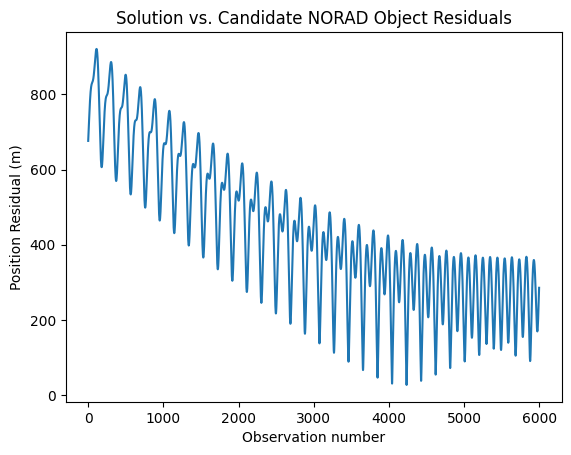

In [42]:
plt.plot(np.sqrt(solution_residuals(t, aligned_solve_sat.model, ref_tle.model)) * 1000)
plt.title("Solution vs. Candidate NORAD Object Residuals")
plt.xlabel("Observation number")
plt.ylabel("Position Residual (m)")